## Using PINNs to Solve Hydrodynamical Equations in 1D

Author :  Sayantan Auddy 

Date   :  13 March 2023

In this notebook we calculate the propagation of a sound wave using Neural Networks, illustrating the cases of linear and nonlinear wave propagation and nonlinear steepening. 

#### Case 1.  
Partial differential equations are solved using finite difference method. Here the Lax method is used to inte-
grate the  flux conservative form of the continuity and momentum equations.

#### Case 2.
We solve the Partial differential equations using PINNs. We then compare the results for various boundary and intial conditions.




### 1.1 Equations

The hydrostatic system with no self-gravity-- 

For an isothermal gas in 1 dimension, the dynamics is governed by continuity eqution and momentum equation. They are given as follows,
$$
\begin{eqnarray}
\frac{\partial \rho}{\partial t} &=& -\frac{\partial}{\partial x}\left(\rho v_{x}\right)\\
\rho\frac{d }{d t}v_{x}&=& -\frac{\partial }{\partial x}P 
\end{eqnarray}\tag{4}
$$

Where eqn (4) represents the equation of continuity and momentum equation. The LHS of eqn (4a) is the the product of density and acceleration and RHS is force due to pressure gradient. Where $d/dt$ is the Lagrangian derivative. In one dimension it is defined as follows,

$$
\begin{equation}
\frac{d}{dt} = \frac{\partial}{\partial t}+v_{x}\frac{\partial}{\partial x}
\end{equation}\tag{5}
$$
And for an isothermal gas,
$$
\begin{equation}
c_{s} = \sqrt{\frac{P}{\rho}}
\end{equation}\tag{6}
$$
Using equation (5) and (6) we can rewrite equation (4b) as

$$
\begin{eqnarray}
\rho\frac{\partial v_{x}}{\partial t}+\rho v_{x}\frac{\partial v_{x}}{\partial x} &=& -c^{2}_{s}\frac{\partial\rho}{\partial x}\nonumber\\
\Rightarrow \rho\frac{\partial v_{x}}{\partial t} +\frac{\partial\rho v_{x} v_{x}}{\partial x} - v_{x}\frac{\partial\rho v_{x}}{\partial x} &=& -c^{2}_{s}\frac{\partial\rho}{\partial x}\nonumber\\
\Rightarrow \rho\frac{\partial v_{x}}{\partial t} - v_{x}\frac{\partial \rho v_{x}}{\partial x} &=&-\frac{\partial \rho v_{x} v_{x}}{\partial x}-c^{2}_{s}\frac{\partial\rho}{\partial x}
\end{eqnarray}\tag{7}
$$

Now substituting equation (4a) in to  (7c) we get,
$$
\begin{eqnarray}
\rho\frac{\partial v_{x}}{\partial t} +v_{x}\frac{\partial \rho}{\partial t} &=& -\frac{\partial\rho v_{x} v_{x}}{\partial x}-c^{2}_{s}\frac{\partial\rho}{\partial x}\nonumber\\
\Rightarrow \frac{\partial\rho v_{x}}{\partial t} &=&-\frac{\partial\rho v_{x} v_{x}}{\partial x}-c^{2}_{s}\frac{\partial\rho}{\partial x}\nonumber
\end{eqnarray}\tag{8}
$$

Hence the flux conservative form of momentum equation and the continuity equation is given by,

$$
\begin{eqnarray}
\frac{\partial \rho}{\partial t} &=& -\frac{\partial}{\partial x}\left(\rho v_{x}\right)\\
\end{eqnarray}\tag{9}
$$
$$
\begin{eqnarray}
\frac{\partial\left(\rho v_{x}\right)}{\partial t} &=&-\frac{\partial}{\partial x}\left(\rho v_{x} v_{x}\right)-c^{2}_{s}\frac{\partial\rho}{\partial x}
\end{eqnarray}\tag{10}
$$

Equation (9) and (10) will decide the dynamics of gas with given boundary and initial condition. 

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np
import os
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Concatenate, Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Lambda
import matplotlib.pyplot as plt
# tf.compat.v1.keras.initializers.he_normal
np.random.seed(1234)
tf.random.set_seed(1234)
%matplotlib inline

Using backend: tensorflow.compat.v1

2023-03-13 18:49:34.093937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 18:49:36.402938: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 18:49:43.427001: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-13 18:49:43.429825: W tensorflow/compiler/xla/stream_executo

Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.




### 1.2 Methodology

The method constructs a neural network approximation. We consider a single neural network with the desired output varibles, $\rho$ and $\vec v$- 

$$
\begin{aligned}
\vec v_\theta(t,x), \rho_\theta(t,x) &\approx \mathcal N_{\rho, v}(X;\theta) \\
% \vec v_\theta(t,x) &\approx \mathcal N_{v}(X;\theta_{v})
\end{aligned}\tag{12}
$$

where $X:= (x,t)$, $\theta_{\rho}$ and $\theta_{v}$ are the parameters for the individual networks. 

<!-- The idea is to first optimize the network parameters of $\mathcal N_{\rho}(X;\theta_{\rho})$ with those of $\mathcal N_{v}(X;\theta_{v})$ fixed and then vice versa, and the process is iterated until convergennce is achieved. -->

In this approach the total loss can be decoupled as:

The PDE losses associated with Eqs
$$
\begin{eqnarray}
\mathcal L_{\rho} =  \frac{1}{N_r}\sum_{i=1}^{N_r} \left|\partial_t \rho_{\theta}\left(t_i^r, x_i^r\right)+ \partial_x (\rho_{\theta}\left(t_i^r, x_i^r\right) \vec v_{\theta}\left(t_i^r, x_i^r\right)) \right|^2 
\end{eqnarray}\tag{13}
$$
$$
\begin{eqnarray}
\mathcal L_{\vec v} =  \frac{1}{N_r}\sum_{i=1}^{N_r}\left|\partial_t \left[\rho_{\theta} \left(t_i^r, x_i^r\right)\vec v_{\theta} \left(t_i^r, x_i^r\right)\right] + \partial_x \left[\rho_{\theta} \left(t_i^r, x_i^r\right)\vec v_{\theta} \left(t_i^r, x_i^r\right)\vec v_{\theta} \left(t_i^r, x_i^r\right)\right]+ c_s^2 \partial_x \rho_{\theta}\left(t_i^r, x_i^r\right)\right|^2
\end{eqnarray}\tag{14}
$$
where $n$ is the total number of collocation points in the domain denoted by $X$ in a number of collocation points $X^r:=\{(t_i^r, x_i^r)\}_{i=1}^{N_r} $

The losses associated with initial and boundary conditions for density $\rho $


$$
    \begin{align*}
   \mathcal L_{\rho_0}(X^0) 
   := 
   \frac{1}{N_0}
   \sum_{i=1}^{N_0} \left|\rho_{\theta}\left(t_i^0, x_i^0\right) - \rho_{0}\left(x_i^0\right)\right|^2
   \quad \text{ and } \quad
   \mathcal L_{\rho_b}(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b} \left|\rho_{\theta}\left(t_i^b, x_i^b\right) - \rho_{b}\left(t_i^b, x_i^b\right)\right|^2
    \end{align*}\tag{15}
$$

in a number of points $X^0:=\{(t^0_i,x^0_i)\}_{i=1}^{N_0} \subset \{0\} \times \mathcal{D}$ and $X^b:=\{(t^b_i,x^b_i)\}_{i=1}^{N_b} \subset (0,T] \times \partial \mathcal{D}$, where $\rho_\theta$ is the neural network approximation of the solution $\rho\colon[0,T] \times \mathcal{D} \to \mathbb{R}$.



The losses associated with initial and boundary conditions for velocity $\vec v_{\theta} $


$$
    \begin{align*}
   \mathcal L_{\vec v_0}(X^0) 
   := 
   \frac{1}{N_0}
   \sum_{i=1}^{N_0} \left|\vec v_{\theta}\left(t_i^0, x_i^0\right) - \vec v_{0}\left(x_i^0\right)\right|^2
   \quad \text{ and } \quad
   \mathcal L_{\vec  v_b}(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b} \left|\vec v\left(t_i^b, x_i^b\right) - \vec v_{b}\left(t_i^b, x_i^b\right)\right|^2
    \end{align*}\tag{16}
$$

in a number of points $X^0:=\{(t^0_i,x^0_i)\}_{i=1}^{N_0} \subset \{0\} \times \mathcal{D}$ and $X^b:=\{(t^b_i,x^b_i)\}_{i=1}^{N_b} \subset (0,T] \times \partial \mathcal{D}$, where $\vec v_\theta$ is the neural network approximation of the solution $\vec v\colon[0,T] \times \mathcal{D} \to \mathbb{R}$.

In this sequential approach the total loss is decoupled as: 

$$
\begin{eqnarray}
\mathcal L_{\mathcal N_{\rho}} =  \mathcal L_{\rho} + \mathcal L_{\rho_0} +\mathcal L_{\rho_b} \\ 
\mathcal L_{\mathcal N{\vec v}} =  \mathcal L_{\vec v} + \mathcal L_{\vec v_0} +\mathcal L_{\vec v_b} 
\end{eqnarray}\tag{17}
$$

The TOTAL LOSS  

$$
\begin{eqnarray}
\mathcal L_{Total} = \mathcal L_{\rho} + \mathcal L_{\rho_0} +\mathcal L_{\rho_b}  +\mathcal L_{\vec v} + \mathcal L_{\vec v_0} +\mathcal L_{\vec v_b}
\end{eqnarray}
$$


In [2]:
#Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
lam = 1.0           # one wavelength
num_of_waves = 2     # the number of waves
#%matplotlib inlinemaxT = 0.5           # maximum time (0.3,0.5,1 second)

rho_1 = 0.03;       # 0.03 linear and  0.3 non-linear wave propagation
rho_o = 1.0          # zeroth order density
cs = 1. ## Is the sound speed
v_1 = (cs*rho_1)/rho_o # velocity perturbation
tmax= 1

output_folder = "figures_waves-" + str(lam) + '_' + str(tmax) + '_' + str(num_of_waves) +  '_' + str(rho_1)

try:
    os.makedirs(output_folder)
except OSError:
    print ("Creation of the directory %s failed/ not needed as it already exit" % output_folder)
else:
    print ("Successfully created the directory %s" % output_folder)


Creation of the directory figures_waves-1.0_1_2_0.03 failed/ not needed as it already exit


In [3]:
## General Network Parameters

learning_rate = 1e-3
num_dense_layers = 3
num_dense_nodes = 64
activation =  "tanh" # "sin" # "sin"

iterations_adam = 6000

# collocation_points 
precision_train = 50 ## collocation points density
hx_train = lam/ precision_train
nx_train = int(1 / hx_train)*num_of_waves
print("The number of collocation points resolving the domain are = {} and at boundaries are = {}".format(nx_train*nx_train*tmax,50*nx_train))


The number of collocation points resolving the domain are = 10000 and at boundaries are = 5000


Compiling model...
Building feed-forward neural network...
'build' took 0.108333 s



/home/sauddy3/PINNS-envcedar/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-03-13 18:49:59.030616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 18:50:02.159170: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-03-13 18:50:02.163341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30971 MB memor

'compile' took 4.228743 s

Initializing variables...


2023-03-13 18:50:03.184319: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


Training model...



2023-03-13 18:50:03.880672: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2b4e1000e1e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-13 18:50:03.880793: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-03-13 18:50:04.117385: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-13 18:50:05.206491: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-13 18:50:07.033967: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                                      Test loss                                                       Test metric
0         [3.96e-02, 2.11e-03, 4.27e-04, 1.81e-01, 9.57e-01, 5.91e-02]    [3.96e-02, 2.11e-03, 4.27e-04, 1.81e-01, 9.57e-01, 5.91e-02]    []  
1000      [1.57e-05, 2.55e-05, 1.19e-06, 2.08e-07, 4.53e-04, 4.42e-04]    [1.57e-05, 2.55e-05, 1.19e-06, 2.08e-07, 4.53e-04, 4.42e-04]    []  
2000      [9.71e-06, 8.93e-06, 4.49e-06, 1.10e-06, 4.49e-04, 4.38e-04]    [9.71e-06, 8.93e-06, 4.49e-06, 1.10e-06, 4.49e-04, 4.38e-04]    []  
3000      [5.67e-06, 4.08e-06, 2.23e-06, 7.85e-07, 4.46e-04, 4.36e-04]    [5.67e-06, 4.08e-06, 2.23e-06, 7.85e-07, 4.46e-04, 4.36e-04]    []  
4000      [3.41e-06, 2.51e-06, 2.60e-06, 9.34e-07, 4.44e-04, 4.35e-04]    [3.41e-06, 2.51e-06, 2.60e-06, 9.34e-07, 4.44e-04, 4.35e-04]    []  
5000      [2.20e-06, 1.65e-06, 2.82e-06, 1.12e-06, 4.42e-04, 4.34e-04]    [2.20e-06, 1.65e-06, 2.82e-06, 1.12e-06, 4.42e-04, 4.34e-04] 

2023-03-13 18:50:30.606931: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1780] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Training model...

Step      Train loss                                                      Test loss                                                       Test metric
6000      [2.34e-06, 1.48e-06, 3.37e-06, 2.66e-06, 4.41e-04, 4.34e-04]    [2.34e-06, 1.48e-06, 3.37e-06, 2.66e-06, 4.41e-04, 4.34e-04]    []  
7000      [3.15e-05, 3.75e-05, 1.41e-05, 7.82e-06, 4.10e-05, 3.96e-05]    [3.15e-05, 3.75e-05, 1.41e-05, 7.82e-06, 4.10e-05, 3.96e-05]        
8000      [1.14e-05, 3.42e-06, 3.26e-06, 3.73e-06, 1.51e-05, 1.53e-05]    [1.14e-05, 3.42e-06, 3.26e-06, 3.73e-06, 1.51e-05, 1.53e-05]        
9000      [9.24e-06, 1.09e-06, 3.38e-06, 3.16e-06, 4.56e-06, 4.67e-06]    [9.24e-06, 1.09e-06, 3.38e-06, 3.16e-06, 4.56e-06, 4.67e-06]        
10000     [4.81e-06, 3.73e-06, 2.78e-06, 2.39e-06, 2.65e-06, 2.37e-06]    [4.81e-06, 3.73e-06, 2.78e-06, 2.39e-06, 2.65e-06, 2.37e-06]        
11000     [5.77e-06, 1.81e-06, 1.68e-06, 1.49e-06, 8.29e-07, 7.36e-07]    [5.77e-06, 1.81e-06, 1.68e-06, 1.49e-06, 8

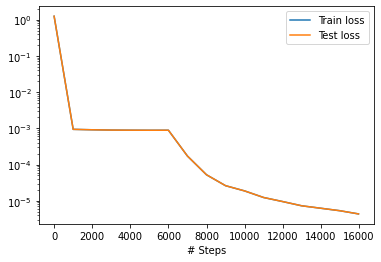

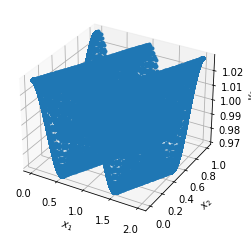

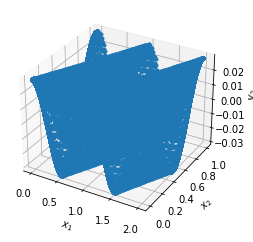

In [4]:
def pde(x, y):

    '''
    The first argument to pde is 2-dimensional vector where the first component(x[:,0]) is 𝑥
    -coordinate and the second componenet (x[:,1]) is the 𝑡-coordinate.

    The second argument is the network output,is 2-dimensional vector where the first component
    (y[:,0]) is density and the second componenet (y[:,1]) is the velocity.
    '''

    cs = 1. ## Is the sound speed

    rho, v = y[:,0:1],y[:,1:2]
    rho_t = dde.grad.jacobian(y, x, i=0, j=1)
    rho_x = dde.grad.jacobian(y, x, i=0, j=0)


    v_t = dde.grad.jacobian(y, x, i=1, j=1)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)


    rho_r = rho_t + v * rho_x + rho * v_x ## The residue from the density equation
    v_r = rho_t*v +rho*v_t + rho_x*v*v + rho*v_x*v + rho*v*v_x  +  cs*cs*rho_x ## The residue from the momentum equation
    # v_r = rho*v_t + rho*v*v_x + cs*cs*rho_x  ### THe momentum equation in 1D-
    
    return [ rho_r, v_r ]

xmin= 0 
xmax= 2       

geom = dde.geometry.Interval(xmin, xmax)
timedomain = dde.geometry.TimeDomain(0, tmax)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def rho_func(x,y):
  return y[:,0:1]


def v_func(x,y):
  return y[:,1:2]

def boundary_l(x, on_boundary):
  return on_boundary and np.isclose(x[0], -1)

def boundary(x, on_boundary):
    return on_boundary


## Boundary Conditions
bc_rho = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, component=0)
bc_v = dde.icbc.boundary_conditions.PeriodicBC(geomtime, 0, lambda _, on_boundary:on_boundary, component=1)

## Boundary Conditions
# bc_rho = dde.icbc.boundary_conditions.PeriodicBC(geomtime, rho_func,  boundary_l, component=0)
# bc_v = dde.icbc.boundary_conditions.PeriodicBC(geomtime, v_func, boundary_l, component=1)

# bc_rho = dde.icbc.boundary_conditions.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary, component=0)
# bc_v = dde.icbc.boundary_conditions.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary, component=1)
# bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)

def fun_rho_0(x):
    ''' Define initial condition for density Returning Eq (11a)'''
    rho_0 = rho_o + rho_1 * tf.cos(2*np.pi*x[:, 0:1]/lam)    
    return rho_0
def fun_v_0(x):
    '''initial condition for velocity -- Returning Eq 11b'''
    v_0 = v_1 * np.cos(2*np.pi*x[:, 0:1]/lam) 
    return v_0

## Initial conditions.
ic_rho = dde.icbc.IC(geomtime,fun_rho_0, lambda _, on_initial: on_initial,component=0)

ic_v = dde.icbc.IC(geomtime,fun_v_0, lambda _, on_initial: on_initial,component=1 )


data = dde.data.TimePDE(geomtime,
                     pde,
                    #  [ic_rho,ic_v,bc_rho,bc_v],
                     [bc_rho,bc_v,ic_rho,ic_v],
                     num_domain=nx_train**2*tmax,   ## Working value 100000,30000,30000
                     num_boundary=50*nx_train,
                     num_initial=50*nx_train,
                    # num_test=10000,
                   )

net = dde.nn.FNN([2] + [num_dense_nodes] * num_dense_layers + [2], activation, "Glorot normal") ## working config 300*3
model = dde.Model(data, net)

model.compile("adam", lr=learning_rate)
model.train(iterations=iterations_adam)
model.compile("L-BFGS")


losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [5]:
def plot_function(time, velocity = False,isplot= False,animation = False):
    
    if animation:
        ## Converting the float (time-input) to an numpy array for animation
        ## Ignore this when the function is called in isolation
        time= np.array([time])
        # print("time",np.asarray(time_array))
    
    for t in time:
        ## Defining the grid
        X = np.linspace(xmin,xmax,1000).reshape(1000, 1)
        t_ = t*np.ones(1000).reshape(1000, 1)        
        X_0 = np.hstack((X, t_))
        
        ## Prediction from the PINNs
        output_0 = model.predict(X_0)        
        rho_pred0 = output_0[:,0:1]
        v_pred0 = output_0[:, 1:2]
        
        ## Linear Theory
        rho_LT  = rho_o + rho_1*np.cos(2*np.pi * X - 2*np.pi*t)
        v_LT = v_1* np.cos(2*np.pi * X - 2*np.pi*t) 
        print("Testing the code at t={} ".format(t))
        
        if isplot :
            plt.figure(1)
            plt.plot(X,rho_pred0-rho_o,label="t={}".format(t))                      
            plt.plot(X,rho_LT-rho_o,'--',label="Analytic_sol")
            plt.ylabel("density")
            plt.xlabel("x")
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            plt.title("PINNs VS LT ")
            plt.savefig(output_folder+'/PINNS_density.png')

            if velocity == True:
                plt.figure(2)
                plt.plot(X,v_pred0,label="t={}".format(t))
                plt.plot(X,v_LT,'--',label="Analytic_sol")
                plt.ylabel("velocity")
                plt.xlabel("x")
                plt.title("PINNs VS LT Velocity")
                # plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
                plt.savefig(output_folder+'/PINNS_velocity.png')
        else:
            return X,rho_pred0,v_pred0,rho_LT,v_LT
             



Testing the code at t=0.001 
Testing the code at t=0.5 
Testing the code at t=0.8 
Testing the code at t=0.001 
Testing the code at t=0.5 
Testing the code at t=0.8 


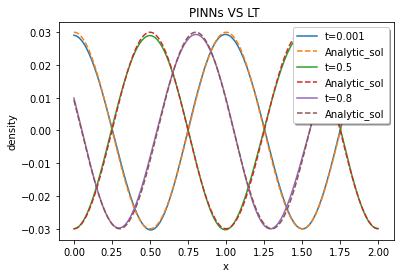

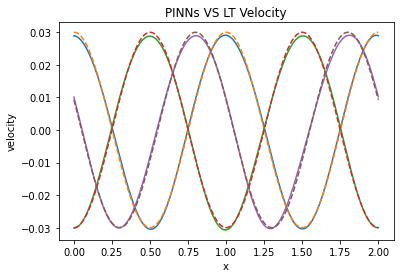

In [6]:
time_array = [0.001,0.5,0.8] 
plot_function(time_array,velocity=True,isplot=True)
for time in time_array:
    X,rho_pred0,v_pred0,rho_LT,v_LT = plot_function(time,velocity=False,isplot=False,animation= True)

### LAX Method

Here the Lax method is used to integrate the flux conservative form of the continuity and momentum equations. For an equation of the form 

$$
\begin{equation}
\frac{\partial f}{\partial t} = -\frac{\partial }{\partial x}\left(fv\right)
\end{equation}\tag{1}
$$

the Lax method is the finite-difference approximation,

$$
\begin{equation}
\frac{f^{n+1}_{j}-\left( f^{n}_{j+1} + f^{n}_{j-1}\right)/2}{\Delta t}=-\frac{f^{n}_{j+1}v^{n}_{j+1}-f^{n}_{j-1}v^{n}_{j-1}}{2\Delta x}
\end{equation}\tag{2}
$$
Forward Time Centered Space (FTCS) method is unconditionally unstable . But the Lax method is conditionally stable if,

$$
\begin{equation}
\nu \equiv \frac{c\Delta t}{\Delta x} \leq 1
\end{equation}\tag{3}
$$

Where $\nu$ is known as Courant number. Physically it means that the signal cannot travel more than $\Delta x$ in $\Delta t$ time.

In [7]:
######### Finite Difference Solution #######
# rho_1 = 0.03
# rho_o = 1            # zeroth order density


def lax_solution(time,lam,num_of_waves,rho_1 = rho_1,gravity=False,isplot = None,animation=None):
    # rho_max = []
    lam = lam          # one wavelength
    num_of_waves  = num_of_waves  
    L = xmax            # Maximum length (two wavelength)
    
    # print("at time= ",time)
    ### Declaring the Constants

    c_s = 1.0            # % Sound Speed        
    nu = 0.3            # courant number (\nu = 2 in 2d)
    rho_1 = rho_1        # question 2a linear wave propagation
    const =  1 # 4.0 * np.pi           # The actual value is 4*pi
    G = 1

    ### Grid X-T 
    N = 1000            # The grid resolution values2d:N =(10,50,100,500)
    dx = float(L/N)      # length spacing        
    dt = nu*2*dx         # time grid spacing

    n = int(time/dt)     # grid points in time
    # print("For time grid n = {} ".format(n))
    
    ## Initializing the ARRAY
    x = np.linspace(0, L, N)
    rho = np.zeros((n,N))
    dphidx = np.zeros((n,N))
    phi = np.zeros((n,N))
    v =np.zeros((n,N))  
    P =np.zeros((n,N))
    
#         print(np.shape(rho))

    jeans = np.sqrt(4*np.pi**2*c_s**2/(const*G*rho_o))
    # print("Jean's Length",jeans)

    
    ######################## Initial Conditions ###########################
    rho[0,:] = rho_o + rho_1* np.cos(2*np.pi*x/lam) # defing the density at t = 0
    
    if gravity == False:
        print("Propagation of Sound wave")
        v_1 = (c_s*rho_1)/rho_o # velocity perturbation
        v[0,:] = v_1 * np.cos(2*np.pi*x/lam) # the velocity at t =0
    else:
        if lam >= jeans:
            print("There is gravitational instabilty  lam = {} > l_jean ={}".format(lam,jeans))
            alpha = np.sqrt(const*G*rho_o-c_s**2*(2*np.pi/lam)**2)
            v_1  = (rho_1/rho_o) * (alpha/(2*np.pi/lam)) ## With gravity        
            v[0,:] = - v_1 * np.sin(2*np.pi*x/lam) # the velocity at t =0
            ## density values from Linear Theory at t
            rho_LT = rho_o + rho_1*np.exp(alpha * time)*np.cos(2*np.pi*x/lam)
            rho_LT_max = np.max(rho_o + rho_1*np.exp(alpha * time)*np.cos(2*np.pi*x/lam))
#             print("rho_theory_max={} and the max density {} at time {}".format(rho_LT_max ,rho_max, round(time,2)))

        else:
            print("There is no gravitational instabilty as lam = {} < l_jean ={}".format(lam,jeans))
            alpha = np.sqrt(c_s**2*(2*np.pi/lam)**2 - const*G*rho_o)
            v_1 = (rho_1/rho_o) * (alpha/(2*np.pi/lam)) # velocity perturbation
            v[0,:] = v_1 * np.cos(2*np.pi*x/lam) # the velocity at t =0

        ## Calculating the potential and the field using FFT    
        phi[0,:],dphidx[0,:] = fft_solver(const*(rho[0,:]-rho_o),L,N, dim = None)

    ######### The Flux term #########
    P=rho*v

    #################################FINITE DIFFERENCE #######################
    for k in range(1,n):

        rho[k,:] = 0.5*(np.roll(rho[k-1,:],-1)+ np.roll(rho[k-1,:],1))-(nu*(np.roll(rho[k-1,:],-1)*np.roll(v[k-1,:],-1)-np.roll(rho[k-1,:],1)*np.roll(v[k-1,:],1)))

        if gravity == False:

            P[k,:] = 0.5*(np.roll(P[k-1,:],-1)+ np.roll(P[k-1,:],1))-(nu*(np.roll(P[k-1,:],-1)*np.roll(v[k-1,:],-1)- np.roll(P[k-1,:],1)*np.roll(v[k-1,:],1)))-((c_s**2)*nu*(np.roll(rho[k-1,:],-1)- np.roll(rho[k-1,:],1)))
        else:

            P[k,:] = 0.5*(np.roll(P[k-1,:],-1)+ np.roll(P[k-1,:],1))-(nu*(np.roll(P[k-1,:],-1)*np.roll(v[k-1,:],-1)- np.roll(P[k-1,:],1)*np.roll(v[k-1,:],1)))\
            -((c_s**2)*nu*(np.roll(rho[k-1,:],-1)- np.roll(rho[k-1,:],1))) -(nu*rho[k-1,:]*(np.roll(phi[k-1,:],-1)- np.roll(phi[k-1,:],1)))#  - dt*rho[k-1,:]* dphidx[k-1,:]  #  # np.roll(rho[k-1,:],-1)*np.roll(dphidx[k-1,:],-1)

            phi[k,:],dphidx[k,:] = fft_solver(const*(rho[k,:]-rho_o),L,N, dim = None) ## Please note we don't use dphidx rather calculate using central differencing

    

        v[k,:] = P[k,:]/rho[k,:]
    rho_max = np.max(rho)   
    ################################# PLOTTING #######################
 
    if isplot : 
        plt.figure(1,figsize=(6,4))
        plt.plot(x,rho[n-1,:]-rho_o,linewidth=1,label="t={}".format(round(time,2)))
        plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
        plt.xlabel(r"$\mathbf{x}$")
        # plt.text(.6,.15,r"dt=%f"%(dt),fontsize=12)
        plt.title("At time {} and rho_1 = {}".format(time,rho_1))
        plt.ylabel(r"$\mathbf{\rho - \rho_{0}}$")

        plt.figure(2,figsize=(6,4))
        plt.plot(x,v[n-1,:],'--',markersize=2,label="t={}".format(round(time,2)))
        plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
        plt.xlabel(r"$\mathbf{x}$")
        plt.title(r"Lax Solution Velocity For $\rho_1$ = {}".format(rho_1))
        plt.ylabel("velocity")

        if gravity:
             #### Plotting the comparison of the \rho_max for FD and Linear Theory 
            
            plt.figure(3,figsize=(6,4))                                
            plt.scatter(time,rho_max)
            plt.scatter(time,rho_LT_max,facecolors='none', edgecolors='r',label="LT")           
            plt.xlabel("t")
            plt.ylabel(r"$\log (\rho_{\rm max} - \rho_{0}) $")
            plt.yscale('log')
            plt.legend(numpoints=1,loc='upper left',fancybox=True,shadow=True)

            ## Plotting the gravitational potential (\phi) and field (g)
            plt.figure(4,figsize=(6,4))
            plt.plot(x,phi[n-1,:],'--',markersize=2,label="t=phi at {}".format(round(time,2)))
#                 plt.plot(x,dphidx[n-1,:],'--',markersize=2,label="g at t={}".format(time))
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            plt.xlabel(r"$\mathbf{x}$")
            plt.title(r"Lax Solution Phi For $\rho_1$ = {}".format(rho_1))
            plt.ylabel(r"$\Phi$")

            plt.figure(5,figsize=(6,4))
#                 plt.plot(x,phi[n-1,:],'--',markersize=2,label="t=phi at {}".format(time))
            plt.plot(x,dphidx[n-1,:],'--',markersize=2,label="g at t={}".format(round(time,2)))
            plt.legend(numpoints=1,loc='upper right',fancybox=True,shadow=True)
            plt.xlabel(r"$\mathbf{x}$")
            plt.title(r"Lax Solution Phi For $\rho_1$ = {}".format(rho_1))
            plt.ylabel(r"$g$")

    else:
        if gravity:
            return x,rho,v,phi,dphidx,n,rho_LT,rho_LT_max,rho_max
        else:
            return x,rho,v,n
            
    ## Clearing the memory
    del rho, dphidx, phi, v, P

Propagation of Sound wave
Propagation of Sound wave


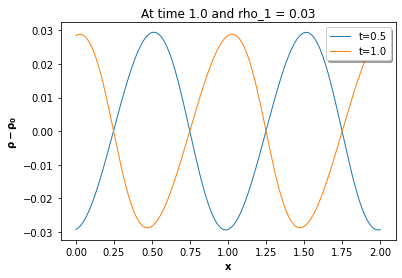

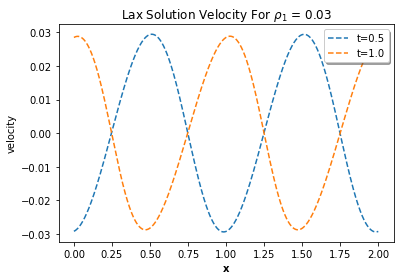

In [8]:
time_array = [0.5,1.0] 
for time in time_array:
    lax_solution(time,lam,num_of_waves,rho_1,isplot=True)



# x,rho,v,n = lax_solution(0.8,lam,num_of_waves,rho_1,isplot=False,animation= True)
# plt.plot(x,rho[n-1])

Testing the code at t=0.1 
Propagation of Sound wave
Testing the code at t=0.5 
Propagation of Sound wave
Testing the code at t=1.0 
Propagation of Sound wave


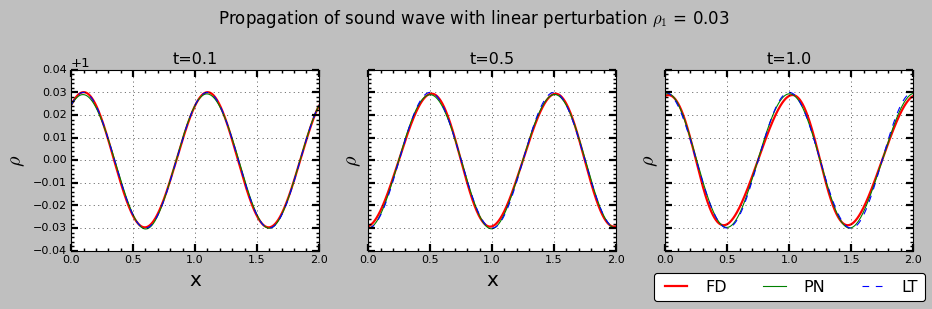

In [12]:
time_array = [0.1,0.5,1.0] 
plt.style.use('classic')
fig, axes = plt.subplots(1,3, figsize=(12,4),sharex=False, sharey=True)
# fig.suptitle(r"PINNS vs FD for $\lambda$ = {} $\lambda_J$ ".format(round(lam/(2*np.pi),2)))
fig.suptitle(r"Propagation of sound wave with linear perturbation $\rho_1$ = {}".format(rho_1),fontsize = 15)
plt.subplots_adjust(hspace = -0.5)
axes = axes.ravel()
# for k, ax in enumerate(axes):
for time, ax in zip(time_array,axes):
    X,rho_pred0,v_pred0,rho_LT,v_LT = plot_function(time,velocity=False,isplot=False,animation= True)
    x,rho,v,n = lax_solution(time,lam,num_of_waves,rho_1,isplot=False,animation= True)
    ax.plot(x,rho[n-1,:],color='red',linewidth=2,label="FD")
    ax.plot(X,rho_pred0,'green',linewidth=1,label="PN")
    ax.plot(X,rho_LT,'--',linewidth=1,label="LT")
    ax.set_title("t={}".format(round(time,2)))
    ax.set_ylabel(r"$\rho$",fontsize = 18)
    # ax.set_ylim(0.96,1.04)
    
    ## To plot the velocity
    
    # ax.plot(x,v[n-1,:],color='yellow',linewidth=2,label="FD")
    # ax.plot(X,v_pred0,'k',label="PN")
    # ax.plot(X,v_LT,'--',linewidth=1,label="LT")
    # ax.set_title("t={}".format(round(time,2)))
    # ax.set_ylabel(r"$v$")
    
    ## Axes settings
    ax.set_xlabel("x",fontsize = 18)
    ax.grid("True")
    ax.minorticks_on()
    ax.tick_params(labelsize=10)
    ax.tick_params(axis='both', which='major',length=6, width=2)
    ax.tick_params(axis='both', which='minor',length=3, width=1.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=False, ncol=3)

plt.tight_layout()
plt.savefig(output_folder+'/DIFF-PINN-FD-Comp'+str(lam)+'_'+str(num_of_waves)+'_'+str(tmax)+'.png', dpi=300)

Testing the code at t=0.1 
Propagation of Sound wave
Testing the code at t=0.5 
Propagation of Sound wave
Testing the code at t=1.0 
Propagation of Sound wave


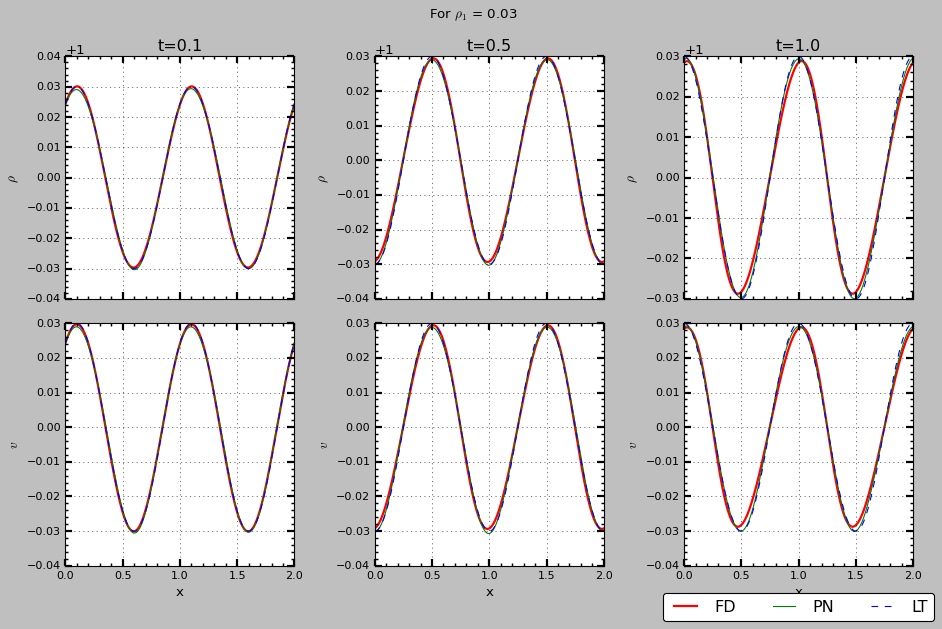

In [10]:
# fig,axes = plt.subplots(2,3)

fig, axes = plt.subplots(2,3, figsize=(12,8),sharex=True, sharey=False)

fig.suptitle(r"For $\rho_1$ = {}".format(rho_1))

for time,j in zip(time_array,(range(len(axes[0])))):
    X,rho_pred0,v_pred0,rho_LT,v_LT = plot_function(time,velocity=False,isplot=False,animation= True)
    x,rho,v,n = lax_solution(time,lam,num_of_waves,rho_1,isplot=False,animation= True)
    axes[0][j].plot(x,rho[n-1,:],color='red',linewidth=2,label="FD")
    axes[0][j].plot(X,rho_pred0,'green',label="PN")
    axes[0][j].plot(X,rho_LT,'--',linewidth=1,label="LT")
    axes[0][j].set_title("t={}".format(round(time,2)))
    axes[0][j].set_ylabel(r"$\rho$")
    # axes[0][j].set_xlabel("x")
    axes[0][j].grid("True")
    axes[0][j].minorticks_on()
    axes[0][j].tick_params(labelsize=10)
    axes[0][j].tick_params(axis='both', which='major',length=6, width=2)
    axes[0][j].tick_params(axis='both', which='minor',length=3, width=1.3)
    
    axes[1][j].plot(x,v[n-1,:],color='red',linewidth=2,label="FD")
    axes[1][j].plot(X,v_pred0,'green',label="PN")
    axes[1][j].plot(X,v_LT,'--',linewidth=1,label="LT")
    # axes[1][j].set_title("t={}".format(round(time,2)))
    axes[1][j].set_ylabel(r"$v$")
    axes[1][j].set_xlabel("x")
    axes[1][j].grid("True")
    axes[1][j].minorticks_on()
    axes[1][j].tick_params(labelsize=10)
    axes[1][j].tick_params(axis='both', which='major',length=6, width=2)
    axes[1][j].tick_params(axis='both', which='minor',length=3, width=1.3)
# plt.show()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=False, ncol=3)

plt.tight_layout()
plt.savefig(output_folder+'/DIFF-PINN-FD-vel-den-Comp'+str(lam)+'_'+str(num_of_waves)+'_'+str(tmax)+'.png', dpi=300)

## To Animate and compare the solutions

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as anim
# from IPython.display import HTML
from pathlib import Path

from matplotlib import animation, rc
# from IPython.display import HTML, Image # For GIF

# rc('animation', html='html5')

from matplotlib.animation import FuncAnimation
# import matplotlib.animation as animation


t = np.linspace(0,tmax,100)
fig, (ax1,ax2), = plt.subplots(2,1)
fig.set_size_inches(8,8)
# ax1.set_xlim([-1, 1])
numDataPoints = len(t-1)
def animate_func(num):
    ax1.clear()  # Clears the figure to update the line, point,   
    ax2.clear()  
    X,rho_pred0,v_pred0,rho_LT,v_LT = plot_function(t[num+1],velocity=False,isplot=False,animation= True)
    x,rho,v,n = lax_solution(t[num+1],lam,num_of_waves,rho_1,isplot=False,animation= True)
    
    lim_y_b = rho_o - rho_1*5 ## To fix the axes ylim auto
    lim_y_u = rho_o + rho_1*5
    ax1.plot(x,rho[n-1,:],color='red',linewidth=2,label="FD")
    ax1.plot(X,rho_pred0,'--k',linewidth=1,label="PN at t={}".format(round(t[num+1],3)))
    # ax1.set_title("t={}".format(round(time,2)))
    ax1.set_ylabel(r"$\rho$")
    ax1.set_xlabel("x")
    ax1.set_ylim([lim_y_b,lim_y_u ])
    ax1.legend(numpoints=1,loc='lower right',fancybox=True,shadow=True)
    
    ax2.plot(x,v[n-1,:],color='yellow',linewidth=2,label="FD")
    ax2.plot(X,v_pred0,'k',label="PN")
    ax2.set_ylabel("$v$")
    ax2.set_xlabel("x")
    ax2.set_ylim([-0.3,0.3 ])
line_ani = FuncAnimation(fig, animate_func, interval=30,   
                                   frames=numDataPoints-1)
  
### saving to m4 using ffmpeg writer
# writervideo = animation.FFMpegWriter(fps=20)
# line_ani.save('instability_comp'+str(lam)+ '.mp4', writer=writervideo)
# ax2.clear()  
# ax4.clear()  # Clears the figure to update the line, point
line_ani.save(output_folder+'/waves'+str(lam)+ '.gif', writer='pillow', fps=60)
plt.close()
plt.show()
print("[INFO]: Animation is complete")

Testing the code at t=0.010101010101010102 
Propagation of Sound wave
Testing the code at t=0.010101010101010102 
Propagation of Sound wave
Testing the code at t=0.020202020202020204 
Propagation of Sound wave
Testing the code at t=0.030303030303030304 
Propagation of Sound wave
Testing the code at t=0.04040404040404041 
Propagation of Sound wave
Testing the code at t=0.05050505050505051 
Propagation of Sound wave
Testing the code at t=0.06060606060606061 
Propagation of Sound wave
Testing the code at t=0.07070707070707072 
Propagation of Sound wave
Testing the code at t=0.08080808080808081 
Propagation of Sound wave
Testing the code at t=0.09090909090909091 
Propagation of Sound wave
Testing the code at t=0.10101010101010102 
Propagation of Sound wave
Testing the code at t=0.11111111111111112 
Propagation of Sound wave
Testing the code at t=0.12121212121212122 
Propagation of Sound wave
Testing the code at t=0.13131313131313133 
Propagation of Sound wave
Testing the code at t=0.141414